# Step 0 - Load packages and example data <a id='step0'></a>

In [8]:
# Set working directory
setwd("/Users/candrews/Documents/Git/shorttermdroughtforecaster/")

# R packages
library(raster)
library(data.table)
library(ggplot2)
library(lubridate)

# Source R code and packages used in weather analysis
source('functions/weatherFunctions.R')

# Latitude and longitude of specific site which data will be gathered
lat <- 35.1266
lng <- -111.5854

# Other set up
currMonth <- month(Sys.Date())
Nleads <- 12
n = 30

# Data
HistDataNormMean <- fread('ExampleData/HistDataNormMean.csv') # Summarized temperature and soil moisture values for the historical normal period (1981 - 2010)
AnomRunStats <- fread('ExampleData/AnomRunStats.csv') #Summarize temperature and soil moisture values for the future period

# Step 1 - Gather point specific (lat, long) historic weather data from gridMet

For a point location (lat, long) historical weather data (1979 – current) is downloaded from [gridMet](http://www.climatologylab.org/gridmet.html), a daily, high-spatial resolution surface meteorological dataset.

The data repo for gridMet data can be found at https://www.northwestknowledge.net/metdata/data/.

Our function to organize this data is [getWeatherData](functions/WeatherFunctions.R).

In [9]:
lat <- as.numeric(lat)
lng <- as.numeric(lng)

print(paste('The coordinates are', lat, ",", lng))

#wdata <- getWeatherData(lat, lng)
wdata <- fread('ExampleData/wdata.csv') # historical weather data for the coordinates. 
str(wdata)


[1] "The coordinates are 35.1266 , -111.5854"
Classes ‘data.table’ and 'data.frame':	15341 obs. of  6 variables:
 $ Date  : chr  "1979-01-01" "1979-01-02" "1979-01-03" "1979-01-04" ...
 $ Year  : int  1979 1979 1979 1979 1979 1979 1979 1979 1979 1979 ...
 $ DOY   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Tmax_C: num  -4.66 1.72 6.12 8.44 7.12 ...
 $ Tmin_C: num  -14.3 -16.32 -8.18 -5.18 -4.94 ...
 $ PPT_cm: num  0 0 0 0 0.176 ...
 - attr(*, ".internal.selfref")=<externalptr> 


# Step 2 - Gather and format short-term predictions from National Weather Service (NWS) <a id='step2'></a>

## Description of data available

The NWS uses "probability of exceedance" curves to give the forecast probability that a temperature or precipitation quantity will be exceeded at the location in question, for the forecast period. 

[temperature probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=t)

[precipitation probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=p)

In addition to the probability of exceedance, a ‘point forecast’ is given for the mean forecasted anomaly and the standard deviation (SD) of that anomaly, as well as percentile (%ile) that this mean will exceed the climatological mean (top left corners of the above figures). These probability of exceedance curves are generated and updated each month for each outlook and region. 

Tabular data for these forecasts are located here:
* [Temperature](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllftd.dat)
* [Precipitation](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllfpd.dat)


## Data access and manipulation

For each set of coordinates, the appropriate region is determined from a shapefile of the [NWS regional map](images/RegionMap). The affiliated temperature and precipitation NWS long-lead forecasts data are grabbed from local copies of the tabular data from the NPS. These data are converted into the units we need for our data manipulation (temperature in Celsius, precipiation in centimeters) and anomalies (the difference between the NWS climatological mean and the forecasted mean) are calculated.

In [10]:
# Determine Region from coordinates and shapefile ------------------------------------------
CD102 <- shapefile(x = 'CD102/CD102.shp')
points <- data.frame(x = lng, y = lat)

coordinates(points) <- ~ x + y 
proj4string(points) <- CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")

CDRegion <- as.numeric(over(points, CD102)$ID4)

# Read in and subset anomaly data -----------------------------------------------------------
TempAnomsWhole <- fread('CurrentAnomalyTempData.csv') # this data is downloaded from the NWS website
TempAnoms <- subset(TempAnomsWhole, CD == CDRegion)
TempAnoms <- TempAnoms[1:Nleads, ]

PPTAnomsWhole <- fread('CurrentAnomalyPPTData.csv') # this data is downloaded from the NWS website
PPTAnoms <- subset(PPTAnomsWhole, CD == CDRegion)
PPTAnoms <- PPTAnoms[1:Nleads, ]

# Convert values and calculate NWS anomalies or correction factors \-------------------------------------------
  
# Temp
TempAnoms$ClimatologicalMEAN_Temp_C <- (TempAnoms$ClimatologicalMEAN - 32) * (5/9)
TempAnoms$ForecastedMEAN_Temp_C <- (TempAnoms$ForecastedMEAN - 32) * (5/9)
  
TempAnoms$ForecastedSD_Temp_C <- (TempAnoms$ForecastedSD) * (5/9)
TempAnoms$Anom_F <- TempAnoms$ForecastedMEAN - TempAnoms$ClimatologicalMEAN
TempAnoms$Anom_C <- TempAnoms$Anom_F * (5/9)
  
# PPT - keep in transformed units for calcs downstream
## PPT - SDs are given in transformed units. Means are in inches. 
backT <- 1/PPTAnoms$PO

# convert
PPTAnoms$ClimatatologicalMEAN_PPT_PO <- PPTAnoms$ClimatologicalMEAN ^ PPTAnoms$PO
PPTAnoms$ClimatatologicalMEAN_PPT_cm <- PPTAnoms$ClimatologicalMEAN * 2.54
  
PPTAnoms$ForecastedMEAN_PPT_PO <- PPTAnoms$ForecastedMEAN ^ PPTAnoms$PO
PPTAnoms$ForecastedMEAN_PPT_cm <- PPTAnoms$ForecastedMEAN * 2.54
  
PPTAnoms$ForecastedSD_PPT_in <- as.numeric(PPTAnoms$ForecastedSD) ^ backT
PPTAnoms$ForecastedSD_PPT_cm <- PPTAnoms$ForecastedSD_PPT_in * 2.54
  
# calc - anomaly NEEDS to be calcualted in transformed units
PPTAnoms$Anom_PO <- PPTAnoms$ForecastedMEAN_PPT_PO - PPTAnoms$ClimatatologicalMEAN_PPT_PO
PPTAnoms$Anom_cm <- PPTAnoms$ForecastedMEAN_PPT_cm - PPTAnoms$ClimatatologicalMEAN_PPT_cm
PPTAnoms$Anom_CF <- PPTAnoms$ForecastedMEAN / PPTAnoms$ClimatologicalMEAN
  
print('NWS Temperature Data')
TempAnoms
print('NWS Precipitation Data')
PPTAnoms

[1] "NWS Temperature Data"


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,ClimatologicalMEAN_Temp_C,ForecastedMEAN_Temp_C,ForecastedSD_Temp_C,Anom_F,Anom_C
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,5,1,97,70.97,69.98,1.2039,1.35,21.100000,21.650000,0.6688333,0.99,0.5500000
2020,5,2,97,69.64,68.80,1.0297,1.14,20.444444,20.911111,0.5720556,0.84,0.4666667
2020,5,3,97,63.00,62.12,1.0835,1.19,16.733333,17.222222,0.6019444,0.88,0.4888889
2020,5,4,97,53.41,52.51,1.2727,1.40,11.394444,11.894444,0.7070556,0.90,0.5000000
2020,5,5,97,43.42,42.38,1.3283,1.44,5.766667,6.344444,0.7379444,1.04,0.5777778
2020,5,6,97,36.88,35.83,1.6065,1.64,2.127778,2.711111,0.8925000,1.05,0.5833333
2020,5,7,97,35.00,34.40,1.8439,1.92,1.333333,1.666667,1.0243889,0.60,0.3333333
2020,5,8,97,38.35,37.68,1.6754,1.76,3.155556,3.527778,0.9307778,0.67,0.3722222
2020,5,9,97,44.15,43.17,1.5151,1.56,6.205556,6.750000,0.8417222,0.98,0.5444444


[1] "NWS Precipitation Data"


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,PO,2.,⋯,98.,ClimatatologicalMEAN_PPT_PO,ClimatatologicalMEAN_PPT_cm,ForecastedMEAN_PPT_PO,ForecastedMEAN_PPT_cm,ForecastedSD_PPT_in,ForecastedSD_PPT_cm,Anom_PO,Anom_cm,Anom_CF
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,5,1,97,4.72,4.72,0.3000,0.30,0.49,7.93,⋯,2.37,2.139102,11.9888,2.139102,11.9888,0.085684155,0.217637755,0.000000000,0.0000,1.000000
2020,5,2,97,5.89,5.89,0.4800,0.48,0.61,9.46,⋯,3.03,2.949649,14.9606,2.949649,14.9606,0.300223478,0.762567633,0.000000000,0.0000,1.000000
2020,5,3,97,5.22,5.20,0.5051,0.51,0.68,7.95,⋯,2.81,3.068190,13.2080,3.076210,13.2588,0.366260638,0.930302021,0.008019568,0.0508,1.003846
2020,5,4,97,3.72,3.66,0.2998,0.30,0.40,7.74,⋯,1.09,1.680322,9.2964,1.691286,9.4488,0.049212913,0.125000799,0.010964782,0.1524,1.016393
2020,5,5,97,3.74,3.33,0.2481,0.25,0.28,9.97,⋯,0.64,1.400504,8.4582,1.446785,9.4996,0.006885773,0.017489865,0.046281068,1.0414,1.123123
2020,5,6,97,3.30,3.30,0.2400,0.24,0.27,10.25,⋯,0.64,1.380380,8.3820,1.380380,8.3820,0.005063911,0.012862334,0.000000000,0.0000,1.000000
2020,5,7,97,3.86,3.42,0.2306,0.24,0.25,10.99,⋯,0.58,1.359899,8.6868,1.401673,9.8044,0.002827725,0.007182422,0.041774783,1.1176,1.128655
2020,5,8,97,3.86,3.68,0.2296,0.23,0.28,9.65,⋯,0.81,1.440248,9.3472,1.459636,9.8044,0.005221036,0.013261433,0.019387234,0.4572,1.048913
2020,5,9,97,3.28,3.27,0.4000,0.40,0.51,6.57,⋯,0.94,1.829866,8.3058,1.832718,8.3312,0.165853818,0.421268697,0.002851785,0.0254,1.003058


# Step 3 - Use multivariate sampling to generate a range of future anomalies for a specific location  <a id='step3'></a>

Because the future forecast for each lead are probability curves of potential values we want to create a numerical distribution of potential futures using the NWS data. To accomplish this, we use multivariate sampling that considers the covariance between historical temperature and precipitation anomalies, as well as the NWS forecast for the mean and standard deviation in the coming months. 

## Historical data 

For these broad forecasts to reflect site-specific climatology we apply these regional anomalies to site-specific historical data. To create our sample, we first calculate monthly mean temperature and the monthly sum of precipitation for each month in a 30 year climatic normal period (1981 - 2020). Then, using the roll apply function, we mean and sum these monthly values to their affiliated NWS lead. The difference between the NWS lead and historical lead data is calculated, to create an array of meteorological anomalies. The covariance between the lead anomaly values is then calculated in order to apply multivariate sampling. The multivariate sample considers each lead period and looks at covariance, the forecasted standard deviation, and the forecasted anomaly. All precipitation calculations are performed in transformed units.

We would expect these generated anomaly values to have the same mean, standard deviation, and covariance structure as our dataset. 

Note: Long-lead forecasts are predictions for rolling 3-month long windows. Temperature values (C) are means across 3-month windows and precipitation values (inches) are sums. For example, a Lead of 1, refers to the months of June-July-August, Lead 2 refers to July-August-September, and so on and so forth. In order to correctly predict monthly values from the lead data we need to look at what leads are affiliated with each month. To switch between leads and months, we create a monthLeads table.

In [11]:
print("Months & Leads Table")

monthLeads <- makeMonthLeadRelationshipTable(TempAnoms)
monthLeads


[1] "Months & Leads Table"


LEAD,Month,lead1,lead2,lead3
<int>,<dbl>,<int>,<dbl>,<dbl>
1,7,1,NA,NA
2,8,2,1,NA
3,9,3,2,1
4,10,4,3,2
5,11,5,4,3
6,12,6,5,4
7,1,7,6,5
8,2,8,7,6
9,3,9,8,7


In [12]:
# Prepare historical data -------------------------------------------------------------------
## Calculate mean daily temperature
wdata$Tmean_C <- rowMeans(wdata[,c('Tmax_C', 'Tmin_C')])

# Determine months
wdata$Month <- month(wdata$Date)
wdata$Date <- NULL
  
# Aggregate to monthly values
monthlyWdata <- wdata[,.(Tmean_C = mean(Tmean_C), PPT_cm = sum(PPT_cm)), .(Month, Year)]

# Convert monthly PPT to inches 
monthlyWdata$PPT_in <- monthlyWdata$PPT_cm / 2.54

# Aggregate to moving left-aligned 3-month periods (NWS lead seasons)
monthlyWdata$Tmean_C_rollMean <- zoo::rollmean(x = monthlyWdata[,c("Tmean_C")],
                                             k = 3, FUN = mean, fill = NA, 
                                             partial = TRUE, align = "left")
monthlyWdata$PPT_in_rollSum <- zoo::rollsum(x = monthlyWdata[,c("PPT_in")],
                                            k = 3, fill = NA, 
                                            partial = TRUE, align = "left")
# Norm
monthlyWdata <- monthlyWdata[monthlyWdata$Year %in% 1981:2010, ]

# Convert moving left-aligned 3-month periods to NWS leads
monthLeads2 <- monthLeads[1:Nleads,]
monthlyWdata <- merge(monthlyWdata, monthLeads2[,1:2])

# Transform PPT_in_rollingSum using powers (PO) from NWS long-long ppt forecasts
monthlyWdata <- merge(monthlyWdata, PPTAnoms[,c('LEAD', 'PO')], by = 'LEAD')
monthlyWdata$PPT_PO_rollSum <- monthlyWdata$PPT_in_rollSum ^ monthlyWdata$PO


In [13]:
# function to create anomaly data 
generatedAnomData <- generateAnomalyData(monthlyWdata, TempAnoms, PPTAnoms, 
                                         leads = seq_len(Nleads), Nleads = Nleads, 
                                         n = n)

# to do walk through of this function
print('This is the code for the generateAnomalyData function')
generateAnomalyData

Attempting to make lead 3 positive definite



              dT_C    dPPT_PO
dT_C     0.3623371 -0.5121736
dPPT_PO -0.5121736  0.2551260


kcov for lead 3 successfuly converged



2 x 2 Matrix of class "dpoMatrix"
              dT_C   dPPT_PO
dT_C     0.4547228 -0.409614
dPPT_PO -0.4096140  0.368980


Attempting to make lead 9 positive definite



              dT_C    dPPT_PO
dT_C     0.7084963 -0.3387278
dPPT_PO -0.3387278  0.1600000


kcov for lead 9 successfuly converged



2 x 2 Matrix of class "dpoMatrix"
              dT_C    dPPT_PO
dT_C     0.7087897 -0.3381127
dPPT_PO -0.3381127  0.1612893
[1] "This is the code for the generateAnomalyData function"


function (monthlyWdata, TempAnoms, PPTAnoms, leads, Nleads, n = 30) 
{
    set.seed(NULL)
    forecast_NWS <- merge(TempAnoms[, c("LEAD", "ClimatologicalMEAN_Temp_C", 
        "ForecastedSD_Temp_C", "Anom_C")], PPTAnoms[, c("LEAD", 
        "ClimatatologicalMEAN_PPT_PO", "ForecastedSD", "Anom_PO")])
    ids <- monthlyWdata[["LEAD"]]
    meteo_anomalies_leads <- data.frame(Lead = ids, dT_C = monthlyWdata[["Tmean_C_rollMean"]] - 
        forecast_NWS[["ClimatologicalMEAN_Temp_C"]][ids], dPPT_PO = monthlyWdata[["PPT_PO_rollSum"]] - 
        forecast_NWS[["ClimatatologicalMEAN_PPT_PO"]][ids])
    cov_anomalies_leads <- by(data = meteo_anomalies_leads[c("dT_C", 
        "dPPT_PO")], INDICES = meteo_anomalies_leads["Lead"], 
        FUN = cov, use = "na.or.complete")
    gen_anomalies_leads <- array(NA, dim = c(length(leads), n, 
        5), dimnames = list(NULL, NULL, c("dT_C", "dPPT_PO", 
        "PT_GenForecasted_PO", "PPT_GenForecasted_cm", "PPT_CF")))
    for (k in seq_along(leads)) {
        kcov <- cov_anomalies_leads[[k]]
        kcov["dT_C", "dT_C"] <- t(forecast_NWS[k, "ForecastedSD_Temp_C"]^2)
        kcov["dPPT_PO", "dPPT_PO"] <- t(forecast_NWS[k, "ForecastedSD"]^2)
        tmp <- tryCatch(MASS::mvrnorm(n = n, mu = as.numeric(forecast_NWS[k, 
            c("Anom_C", "Anom_PO")]), Sigma = kcov, empirical = TRUE), 
            error = function(e) {
                message(paste("Attempting to make lead", k, "positive definite"))
                print(kcov)
                kcov2 <- Matrix::nearPD(x = kcov, keepDiag = FALSE, 
                  maxit = 1000)
                if (kcov2[["converged"]]) {
                  message(paste("kcov for lead", k, "successfuly converged"))
                  print(kcov2$mat)
                  tmp <- MASS::mvrnorm(n = n, mu = as.numeric(forecast_NWS[k, 
                    c("Anom_C", "Anom_PO")]), Sigma = kcov2$mat, 
                    empirical = TRUE)
                }
                else {
                  message(paste("drawing independent anomalies for lead", 
                    k))
                  kcov["dPPT_PO", "dT_C"] <- kcov["dT_C", "dPPT_PO"] <- 0
                  tmp <- MASS::mvrnorm(n = n, mu = as.numeric(forecast_NWS[k, 
                    c("Anom_C", "Anom_PO")]), Sigma = kcov, empirical = TRUE)
                }
                return(tmp)
            })
        gen_anomalies_leads[k, , c(1, 2)] <- tmp
    }
    gen_anomalies_leads[, , "PT_GenForecasted_PO"] <- gen_anomalies_leads[, 
        , "dPPT_PO"] + PPTAnoms$ClimatatologicalMEAN_PPT_PO[1:12]
    backT <- 1/PPTAnoms$PO[1:12]
    gen_anomalies_leads[, , "PPT_GenForecasted_cm"] <- ((gen_anomalies_leads[, 
        , "PT_GenForecasted_PO"])^backT) * 2.54
    gen_anomalies_leads[, , "PPT_CF"] <- gen_anomalies_leads[, 
        , "PPT_GenForecasted_cm"]/PPTAnoms$ClimatatologicalMEAN_PPT_cm[1:12]
    return(gen_anomalies_leads)
}
<bytecode: 0x7f8c380f1a30>

[1] "Temperature Anomaly by LEAD"
    LEAD Univariate_mean    MVMean  NWS_Anom
 1:    1      0.60961802 0.5500000 0.5500000
 2:    2      0.52134136 0.4666667 0.4666667
 3:    3      0.55221182 0.4888889 0.4888889
 4:    4      0.64006651 0.5000000 0.5000000
 5:    5      0.68693004 0.5777778 0.5777778
 6:    6      0.89844083 0.5833333 0.5833333
 7:    7      0.31530480 0.3333333 0.3333333
 8:    8      0.49824254 0.3722222 0.3722222
 9:    9      0.80877001 0.5444444 0.5444444
10:   10      0.24859234 0.2833333 0.2833333
11:   11      0.07013803 0.3000000 0.3000000
12:   12      0.51513004 0.5333333 0.5333333
[1] "Precipitation Anomaly by LEAD"
    LEAD UVNWSmean MVGenMean NWS_PPT_CF
 1:    1 0.9476018  1.020199   1.000000
 2:    2 0.9948980  1.013452   1.000000
 3:    3 1.0242594  1.016957   1.003846
 4:    4 1.0000712  1.073720   1.016393
 5:    5 1.1857287  1.268756   1.123123
 6:    6 0.9781940  1.147802   1.000000
 7:    7 1.5578363  1.318864   1.128655
 8:    8 1.1590512  1.166

Warning message:
“Removed 7 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 12 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


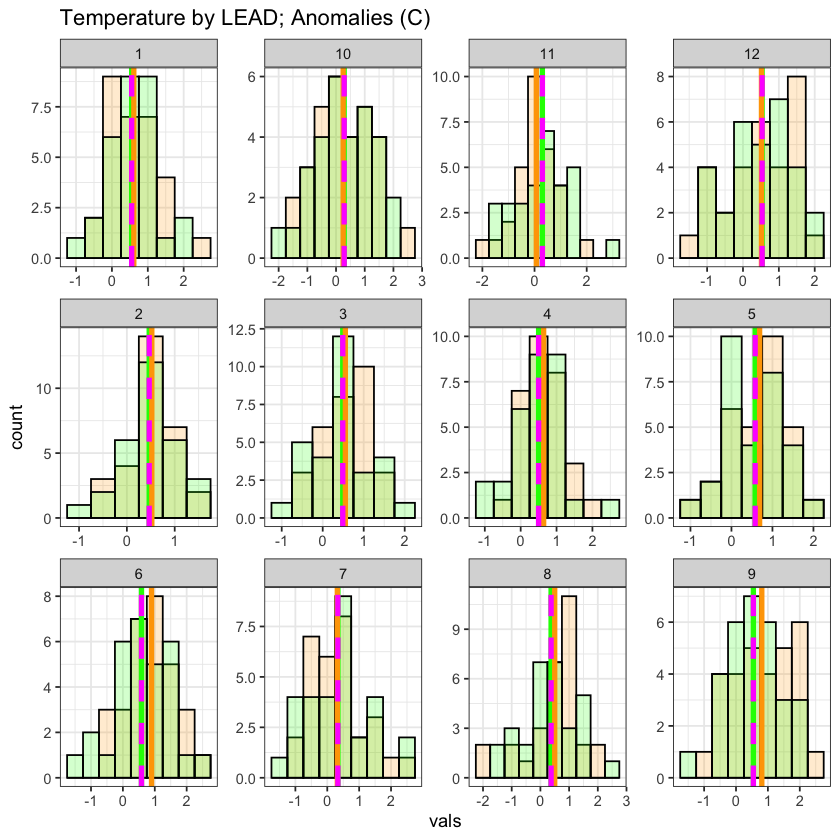

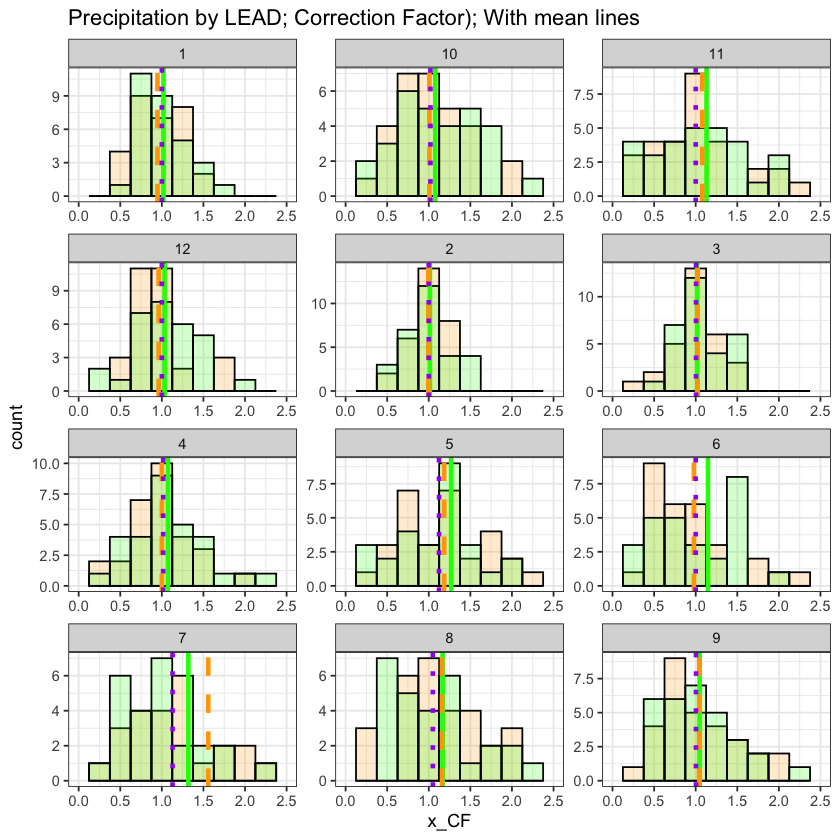

In [15]:
#------ Check generated anomalies against NWS anomalies
# --------- Expection - Mean of predicted multivariate anomalies to be the same as NWS data

# --------- 1: NWS Mean (MAGENTA)
# --------- 1: Random Univariate sample for comparison (ORANGE)
# --------- 2: Multivariate anomalies (GREEN)

print('Temperature Anomaly by LEAD')
source('figureCode/testFigs/LEADS/TempbyLeads.R')

print('Precipitation Anomaly by LEAD')
source('figureCode/testFigs/LEADS/PPTbyLeads_CorrectionFactor.R')


# Step 4 - Bias correction of anomaly forecasts   <a id='step4'></a>

We apply a bias correction factor to the multivariate anomaly predictions. 

Any draw of multivariate anomalies might result in an overprediction or underprection of values. This is especially evident for the precipitation anomaly correction factor, where the transformation of our Anom prediction (in transformed units) from a normal distribution curve, to one that is right-skewed (in centimeters) and converted to a correction factor leads to 'drifting' from the NWS Corrrection Factor values.

![image](SamplingExplorePPT.png)

![image](SamplingExploreTemp.png)


This bias correction is calculated by dividing the mean of the multivariate sampled distribution lead correction factor by the NWS correction factor for precipiation, and by taking the differenve between the multivariate anomaly mean and the NWS anomaly mean for Temperature. This bias correction is then applied to the entire distribution per lead.

In [18]:
# Step 2.1 - Correction factor to the correction factor based on mean -------------------------------

### Temperature
tempGenAnoms <- data.table(generatedAnomData [, , "dT_C"])
tempGenAnoms$LEAD <- row.names(tempGenAnoms)
tempGenAnoms <- melt(tempGenAnoms, id.vars = 'LEAD')
tempGenAnoms <- tempGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]

TempBiasCF <- TempAnoms$Anom_C - tempGenAnoms$MVGenMean 

print('Temperature Anomaly Bias Correction Factors per Lead')
print(cbind(NWSAnomMean  = TempAnoms$Anom_C , MVAnomMEan = tempGenAnoms$MVGenMean,  TempBiasCF))

generatedAnomData [, , "dT_C"] <- generatedAnomData [, , "dT_C"] + TempBiasCF

### Precipitation
pptGenAnoms <- data.table(generatedAnomData [, , "PPT_CF"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]

PPTBiasCF <- PPTAnoms$Anom_CF / pptGenAnomsMean$MVGenMean 

print('Precipitation Anomaly Bias Correction Factors per Lead')
print(cbind(NWSAnomMean  = PPTAnoms$Anom_CF, MVAnomMean = pptGenAnomsMean$MVGenMean,  PPTBiasCF))

generatedAnomData [, , "PPT_CF"] <- generatedAnomData [, , "PPT_CF"] * PPTBiasCF

##### ------ Recalculate PPT_GenForecasted_cm
## ----- need for figures but not used anywhere in analysis
generatedAnomData[, , 'PPT_GenForecasted_cm'] <-
generatedAnomData [, , "PPT_CF"] * PPTAnoms$ClimatatologicalMEAN_PPT_cm
  

[1] "Temperature Anomaly Bias Correction Factors per Lead"
      NWSAnomMean MVAnomMEan    TempBiasCF
 [1,]   0.5500000  0.5500000  0.000000e+00
 [2,]   0.4666667  0.4666667  5.551115e-17
 [3,]   0.4888889  0.4888889 -5.551115e-17
 [4,]   0.5000000  0.5000000 -5.551115e-17
 [5,]   0.5777778  0.5777778  1.110223e-16
 [6,]   0.5833333  0.5833333  0.000000e+00
 [7,]   0.3333333  0.3333333  5.551115e-17
 [8,]   0.3722222  0.3722222  1.110223e-16
 [9,]   0.5444444  0.5444444  0.000000e+00
[10,]   0.2833333  0.2833333  1.110223e-16
[11,]   0.3000000  0.3000000  5.551115e-17
[12,]   0.5333333  0.5333333 -1.110223e-16
[1] "Precipitation Anomaly Bias Correction Factors per Lead"
      NWSAnomMean MVAnomMean PPTBiasCF
 [1,]    1.000000   1.020199 0.9802013
 [2,]    1.000000   1.013452 0.9867269
 [3,]    1.003846   1.016957 0.9871078
 [4,]    1.016393   1.073720 0.9466097
 [5,]    1.123123   1.268756 0.8852162
 [6,]    1.000000   1.147802 0.8712306
 [7,]    1.128655   1.318864 0.8557781
 [8,]    

[1] "Temperature Anomaly by LEAD"
    LEAD Univariate_mean    MVMean  NWS_Anom
 1:    1      0.57088723 0.5500000 0.5500000
 2:    2      0.42609838 0.4666667 0.4666667
 3:    3      0.52466322 0.4888889 0.4888889
 4:    4      0.54597557 0.5000000 0.5000000
 5:    5      0.72868682 0.5777778 0.5777778
 6:    6      0.53350685 0.5833333 0.5833333
 7:    7      0.09320508 0.3333333 0.3333333
 8:    8      0.20230821 0.3722222 0.3722222
 9:    9      0.53774507 0.5444444 0.5444444
10:   10      0.33749726 0.2833333 0.2833333
11:   11      0.37002167 0.3000000 0.3000000
12:   12      0.56436621 0.5333333 0.5333333
[1] "Precipitation Anomaly by LEAD"
[1] "Table of Means - Precipitation Correction Factor"
    LEAD UVNWSmean MVGenMean NWS_PPT_CF
 1:    1 1.0083463  1.000000   1.000000
 2:    2 1.0743351  1.000000   1.000000
 3:    3 1.0076268  1.003846   1.003846
 4:    4 1.0296883  1.016393   1.016393
 5:    5 1.2258717  1.123123   1.123123
 6:    6 1.0229710  1.000000   1.000000
 7:    7 1

Warning message:
“Removed 7 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 9 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


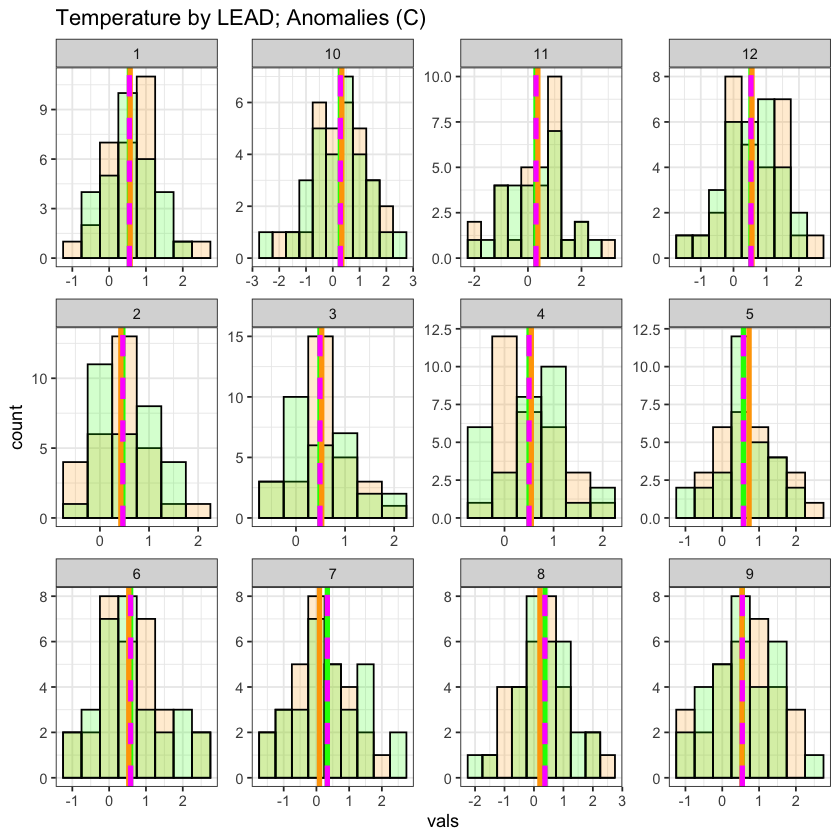

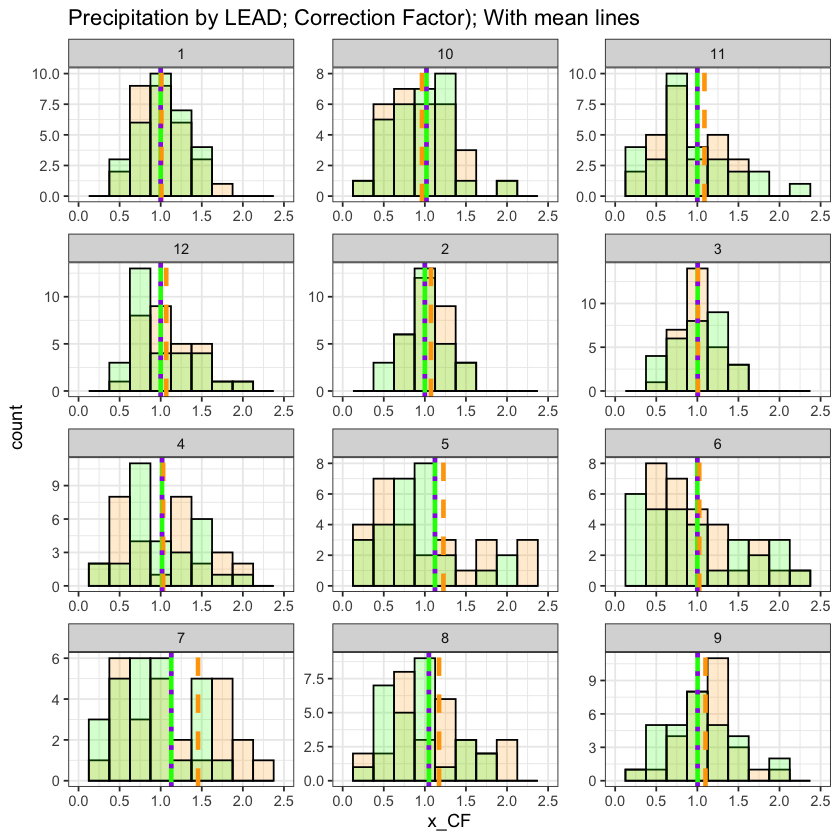

In [9]:
#------ Check generated anomalies against NWS anomalies
# --------- Expection - Mean of predicted multivariate anomalies to be the same as NWS data

# --------- 1: NWS Mean (MAGENTA)
# --------- 1: Random Univariate sample for comparison (ORANGE)
# --------- 2: Multivariate anomalies (GREEN)

print('Temperature Anomaly by LEAD')
source('figureCode/testFigs/LEADS/TempbyLeads.R')

print('Precipitation Anomaly by LEAD')
source('figureCode/testFigs/LEADS/PPTbyLeads_CorrectionFactor.R')

# Step 5 - Integrate future anomalies with historical data to create future weather dataset <a id='step5'></a>

Next, the anomalies generated for each lead must be transformed into monthly values so we can apply the anomalies to the historical data. Using the monthLeads table we loop through each month and find the affiliated leads. Values are then averaged across leads for monthly temperature anomaly and precipiation correction factor.

Finally, these monthly anomalies are then added (temp) or multipled (ppt) to each day in the relative month across the historical series, to generate future daily data for a 30 year period.


In [10]:
# Step 3 Get monthly averages across leads --------------------------------------------------
MonthlyAnoms <- data.frame()
for(nn in 1:n){
    print(nn)
    
    # Step 3 Get monthly averages across leads --------------------------------------------------
    OneYearAnom <- generatedAnomData[ , nn, ]
    OneYearAnom  <- cbind(OneYearAnom, Climatological_MEAN_cm = PPTAnoms$ClimatatologicalMEAN_PPT_cm[1:12])
    OneYearAnom <- cbind(OneYearAnom, Anom_cm = OneYearAnom[,4] - OneYearAnom[,6])
    
    yearlydat <- data.frame(matrix(nrow = 12, ncol = 3))
    names(yearlydat) <- c('tempAnom', 'pptAnom_cm', 'pptAnom_CF')
    yearlydat$Month <- as.numeric(row.names(yearlydat))
    
    for(m in c(yearlydat$Month)){ # for each month, m, in a year, nn
    
      mLeads <- c(t(monthLeads[monthLeads$Month == m, 3:5]))

      #temp
      yearlydat[m, 1] <- mean(OneYearAnom[mLeads, 'dT_C'], na.rm = TRUE) 
      
      # ppt cm
      yearlydat[m, 2] <-  mean(OneYearAnom[mLeads, 'Anom_cm'], na.rm = TRUE)/3
      
      # ppt correction factor
      yearlydat[m, 3] <-  mean(OneYearAnom[mLeads, 'PPT_CF'], na.rm = TRUE)

    }
        MonthlyAnoms <- rbind(MonthlyAnoms, yearlydat)
  }
  


print('summary of weather data before anomalies')
summary(wdata)
### Find month in wdata and merge anomalies
wdata$Month <-  month(as.Date(strptime(paste(wdata$Year, wdata$DOY), format="%Y %j"), format="%m-%d-%Y"))
wdata <- merge(wdata, yearlydat)

### Temp ------------------------------------------------------------------------------------ 
wdata$Tmax_C <- wdata$Tmax_C + wdata$tempAnom
wdata$Tmin_C <- wdata$Tmin_C + wdata$tempAnom

### Precip ----------------------------------------------------------------------------
wdata$PPT_cm <- wdata$PPT_cm * wdata$pptAnom_CF

# That's it
wdata <- wdata[,c('Year', 'DOY', 'Tmax_C', 'Tmin_C', 'PPT_cm')]
print('summary of weather data after anomalies')
summary(wdata)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] "summary of weather data before anomalies"


      Year           DOY            Tmax_C           Tmin_C       
 Min.   :1979   Min.   :  1.0   Min.   :-8.912   Min.   :-25.309  
 1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.202   1st Qu.: -4.579  
 Median :2000   Median :183.0   Median :17.783   Median :  0.759  
 Mean   :2000   Mean   :183.1   Mean   :17.381   Mean   :  1.290  
 3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:24.950   3rd Qu.:  7.560  
 Max.   :2020   Max.   :366.0   Max.   :44.891   Max.   : 32.233  
     PPT_cm           Tmean_C            Month       
 Min.   :0.00000   Min.   :-16.955   Min.   : 1.000  
 1st Qu.:0.00000   1st Qu.:  2.837   1st Qu.: 4.000  
 Median :0.00000   Median :  9.218   Median : 7.000  
 Mean   :0.15377   Mean   :  9.335   Mean   : 6.523  
 3rd Qu.:0.06728   3rd Qu.: 16.329   3rd Qu.:10.000  
 Max.   :9.29819   Max.   : 38.241   Max.   :12.000  

[1] "summary of weather data after anomalies"


      Year           DOY            Tmax_C           Tmin_C       
 Min.   :1979   Min.   :  1.0   Min.   :-9.199   Min.   :-25.264  
 1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.135   1st Qu.: -4.669  
 Median :2000   Median :183.0   Median :17.917   Median :  1.005  
 Mean   :2000   Mean   :183.1   Mean   :17.611   Mean   :  1.521  
 3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.420   3rd Qu.:  8.166  
 Max.   :2020   Max.   :366.0   Max.   :46.268   Max.   : 33.611  
     PPT_cm        
 Min.   : 0.00000  
 1st Qu.: 0.00000  
 Median : 0.00000  
 Mean   : 0.16943  
 3rd Qu.: 0.07182  
 Max.   :10.73094  

### Check  generated monthly anom data vs. NWS data (NWS lead data averaged to correct month)

[1] "Density plots of monthly anomalies used in SOILWAT2 vs NWS"


Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


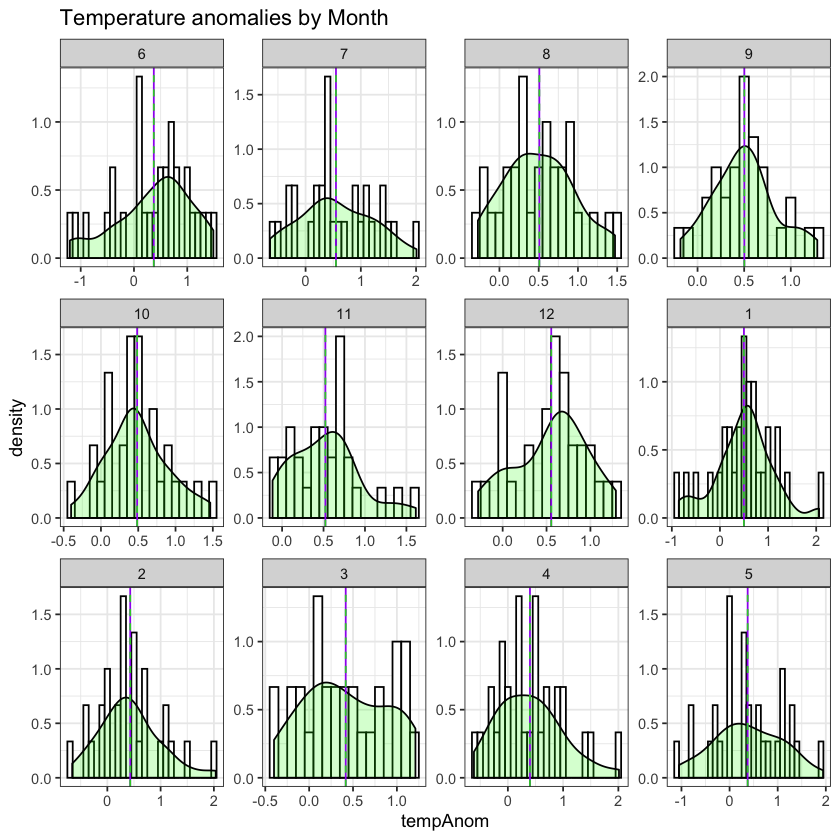

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 24 rows containing missing values (geom_bar).”


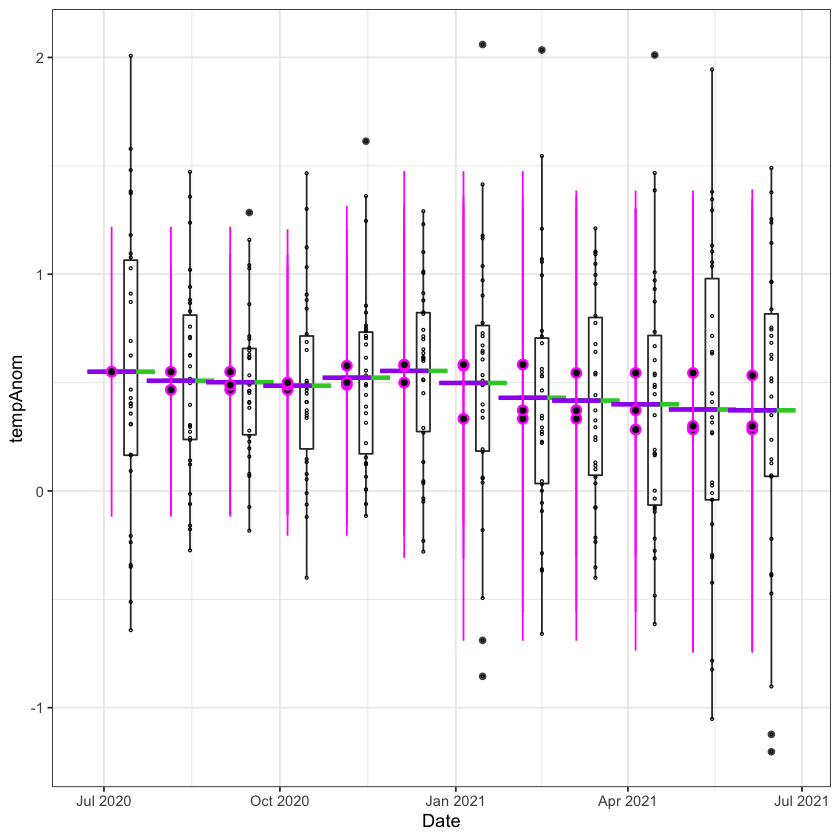

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


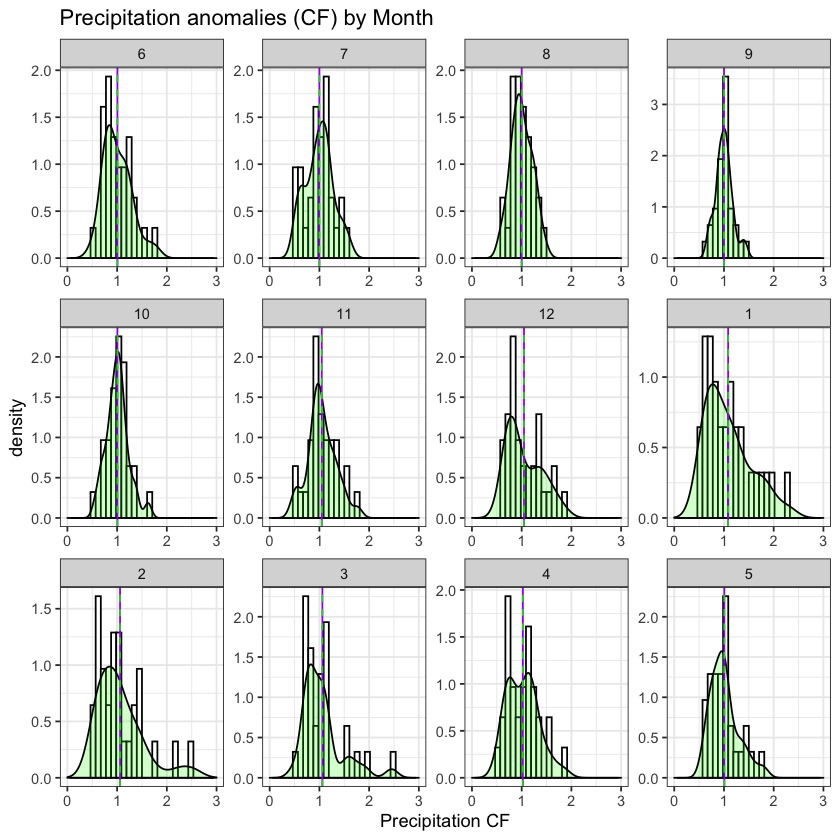

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 16 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 16 rows containing non-finite values (stat_density).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


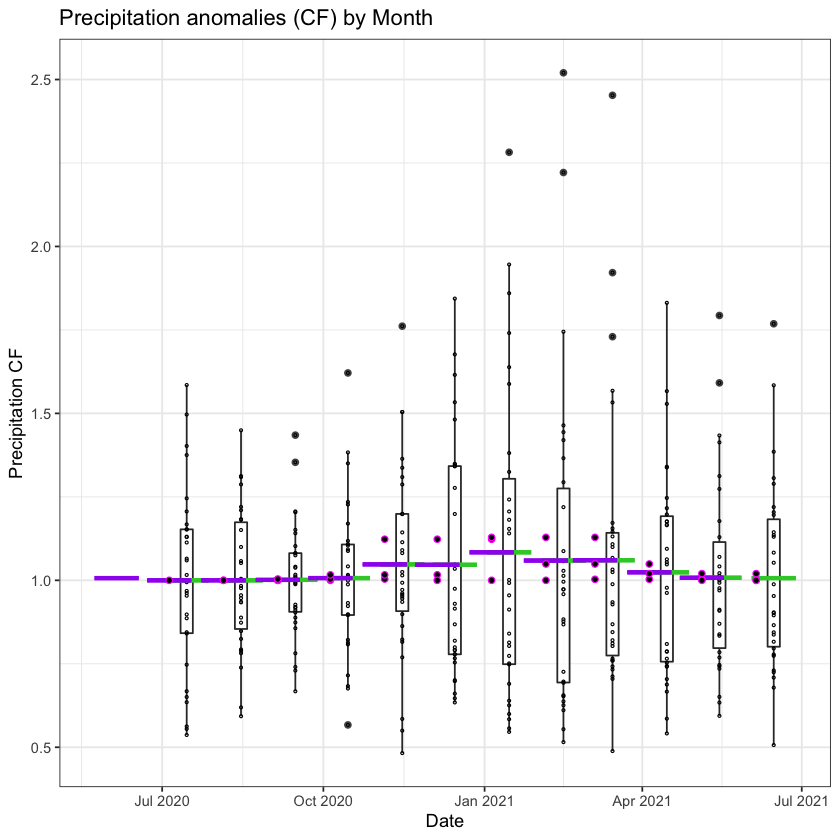

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


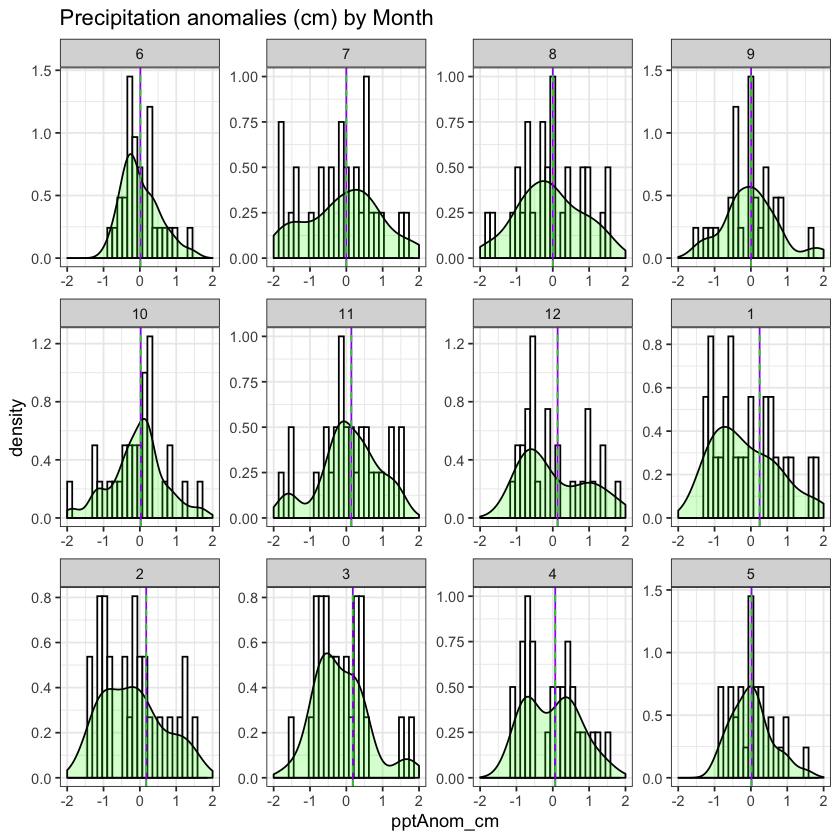

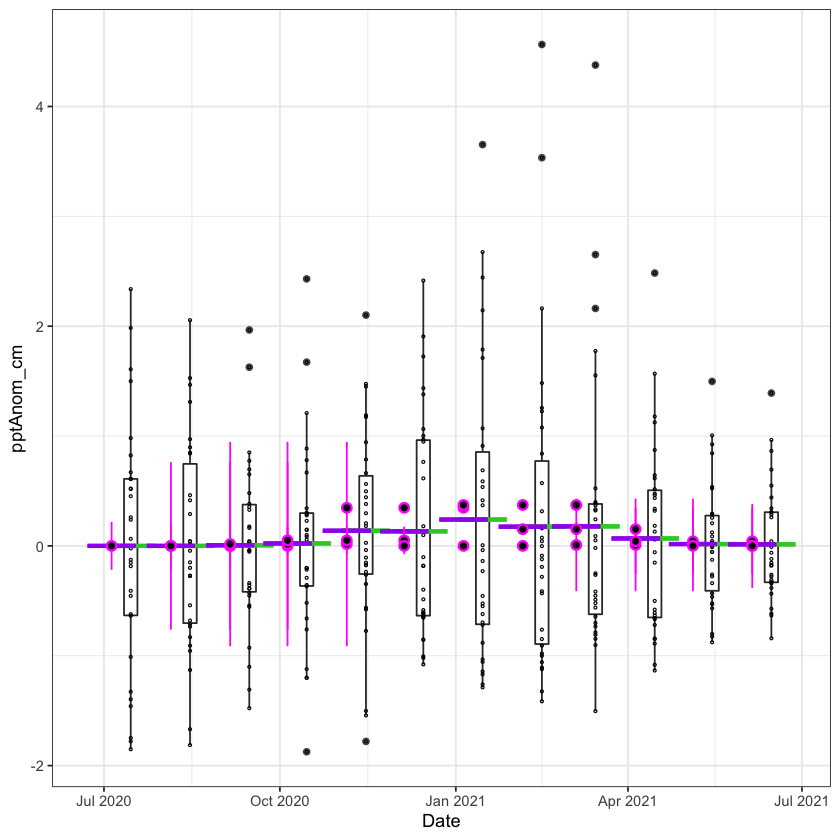

In [11]:
# -------- 1 Monthly multivariate anomalies in green
# -------- 2: Monthly NWS forecasts in magenta
source('figureCode/testFigs/MONTHLY_NWSvsGeneratedAnoms.R')

# Step 6 - Use weather data to simulate futures <a id='step6'></a>
Next, three-year long SOILWAT2 simulations are run using this data. First year is observed data for spin up , second year is part observed and the future, third year is the rest of the future and then dummy data after today's date + 12 months. The anomalies are applied to each year in the historical record for each future (i.e. 30 years). EAch year is run individually so therre is proper spin up and not confound the accumulation of certain conditions and represent the range of possible conditions at the site. This entire process is repeated 30 times, resulting in 900 years.

# Step 7 - Results <a id='step7'></a>

Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 342 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”


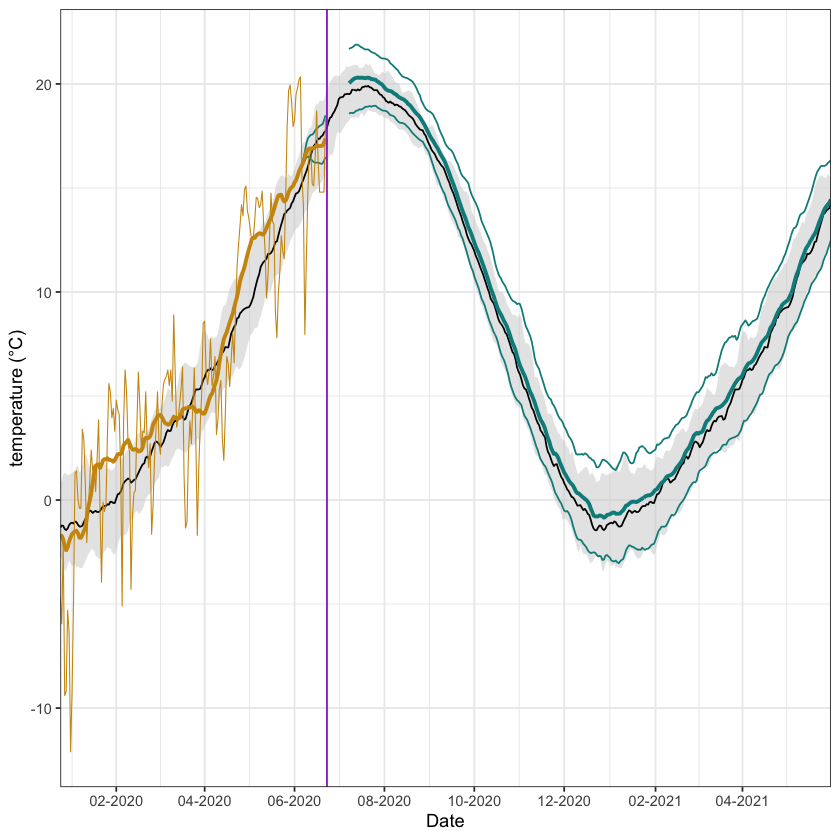

Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning messa

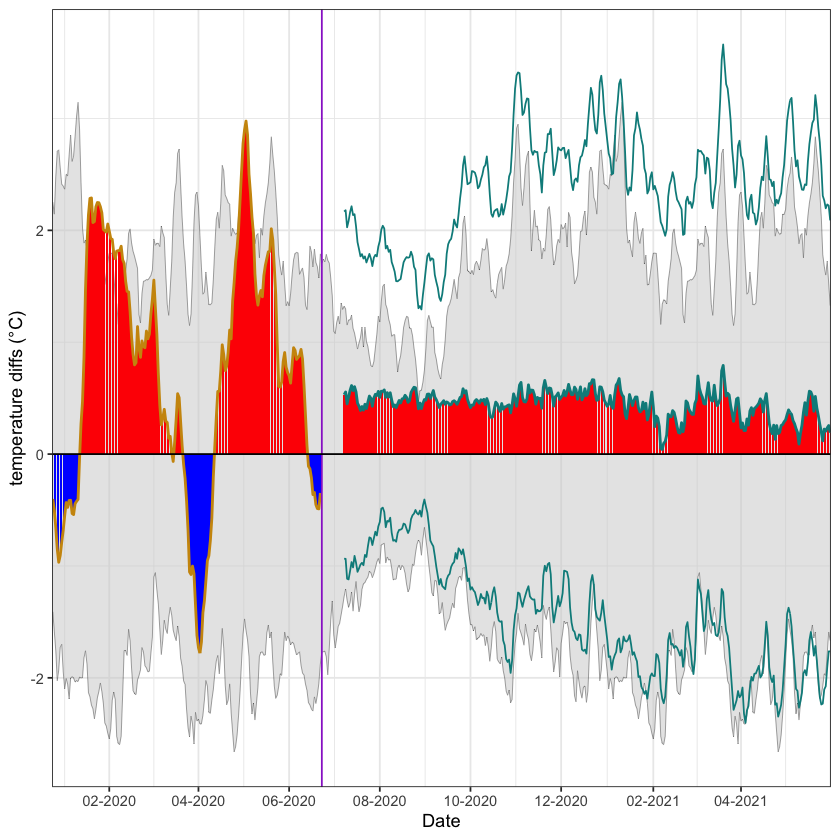

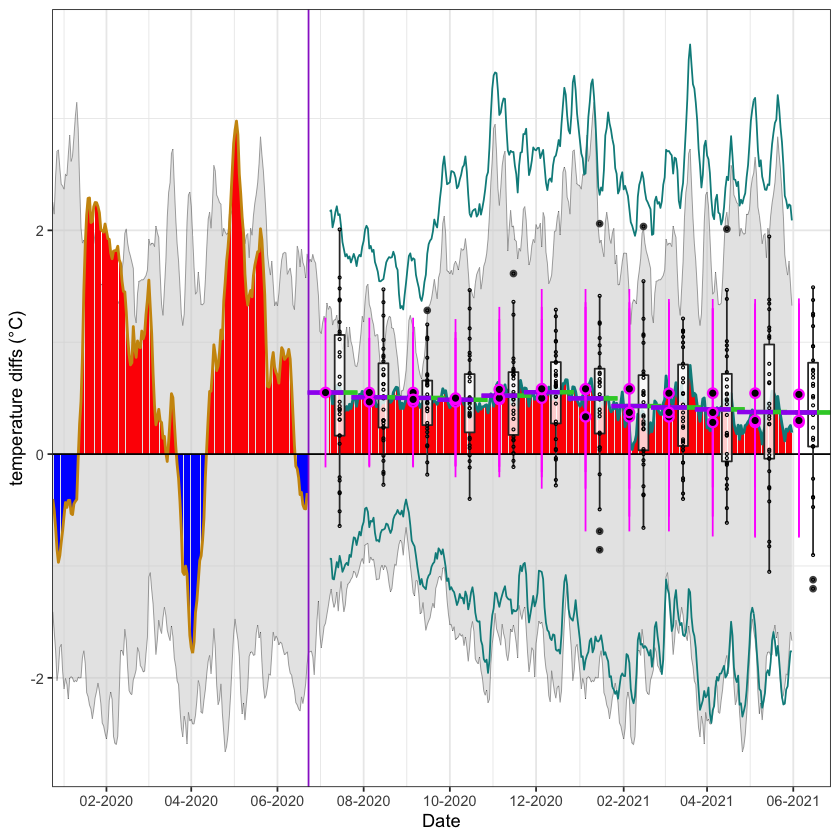

In [12]:
####### This is a lot of code!
source('figureCode/presentationFigs/Temperature.R')


Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 342 rows containing missing values (position_stack).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”


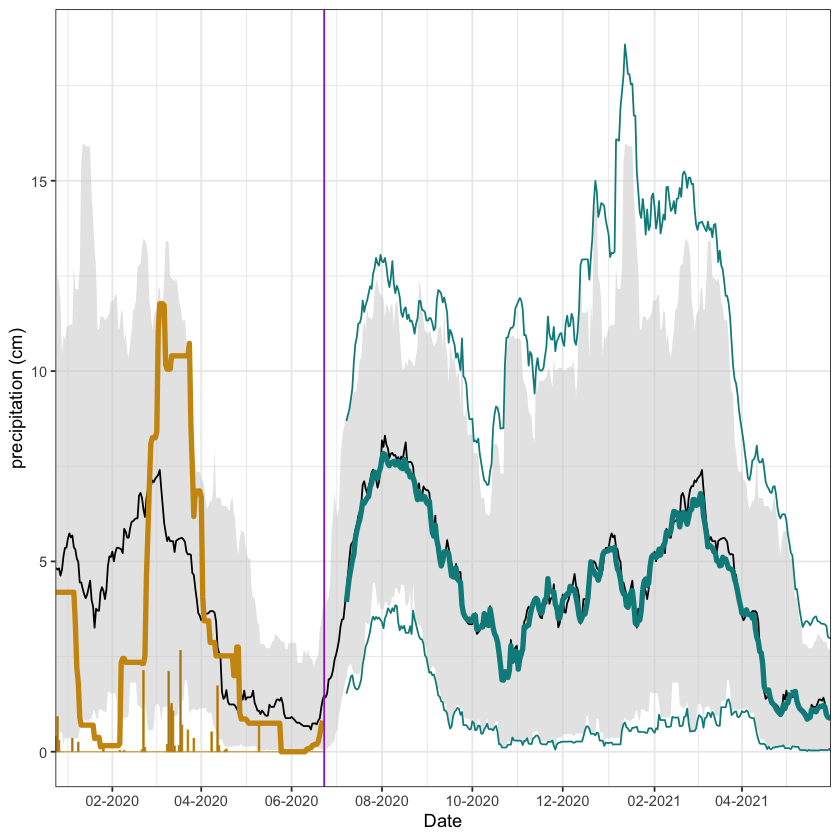

Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning messa

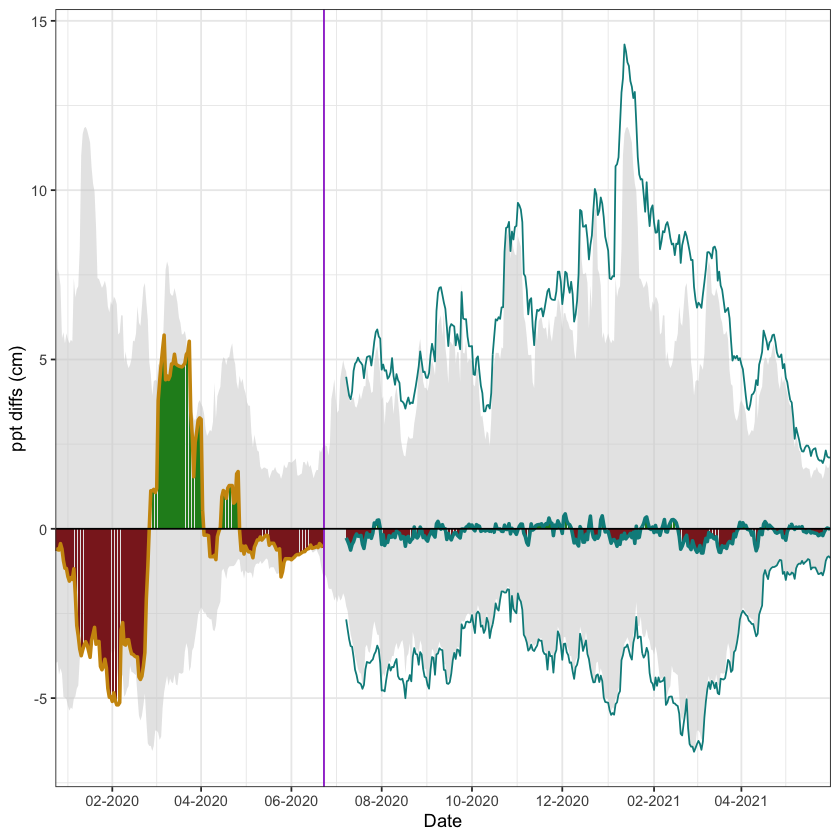

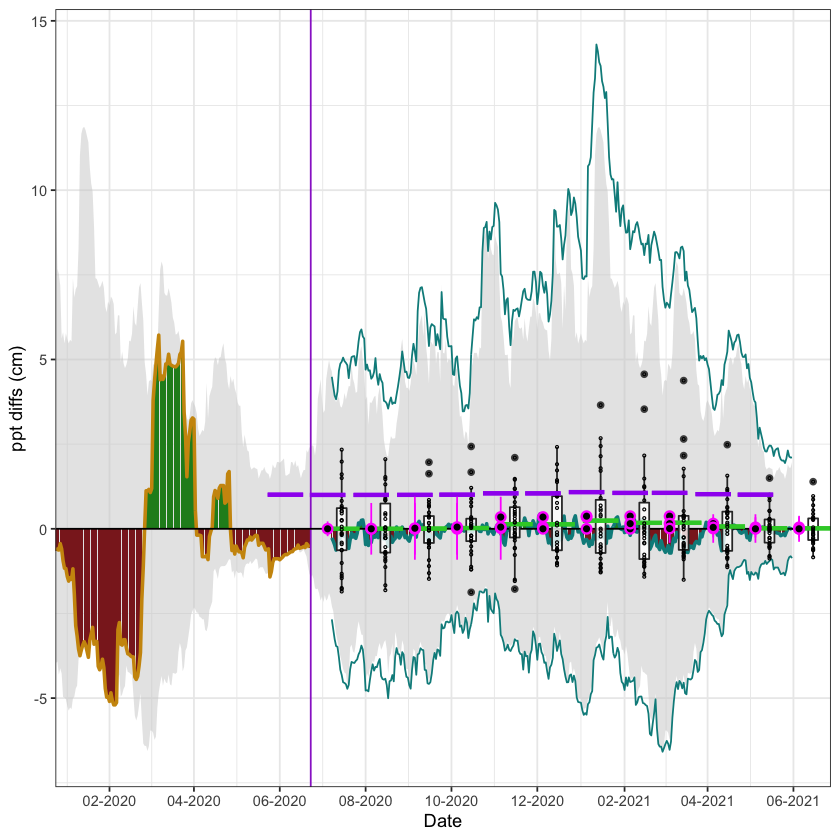

In [13]:
source('figureCode/presentationFigs/precipitation.R')

Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 342 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”
Warning message:
“Removed 196 rows containing missing values (geom_path).”


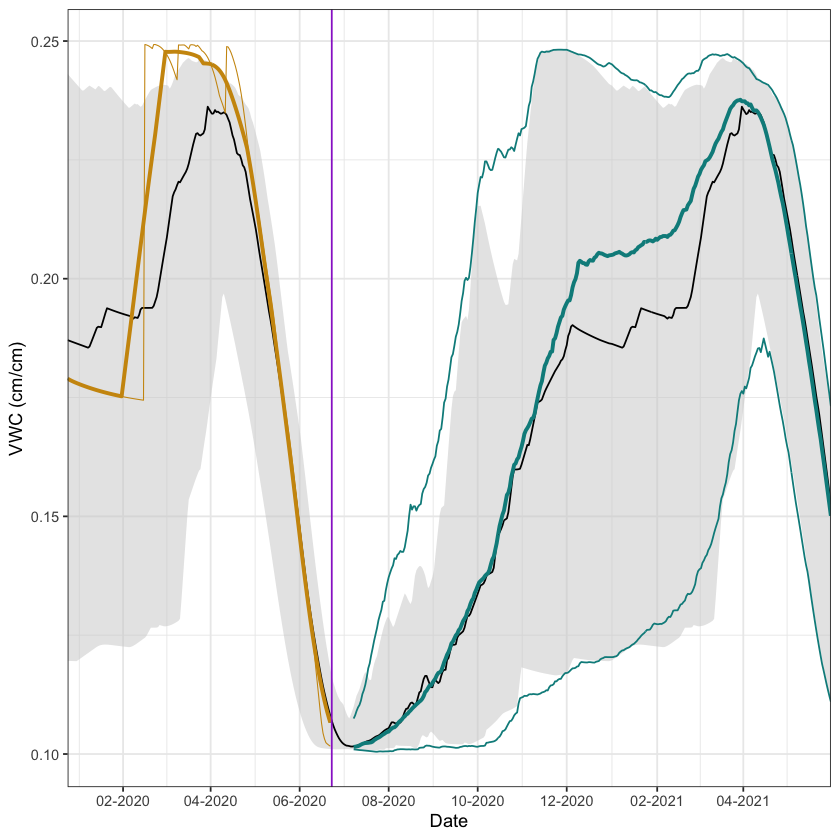

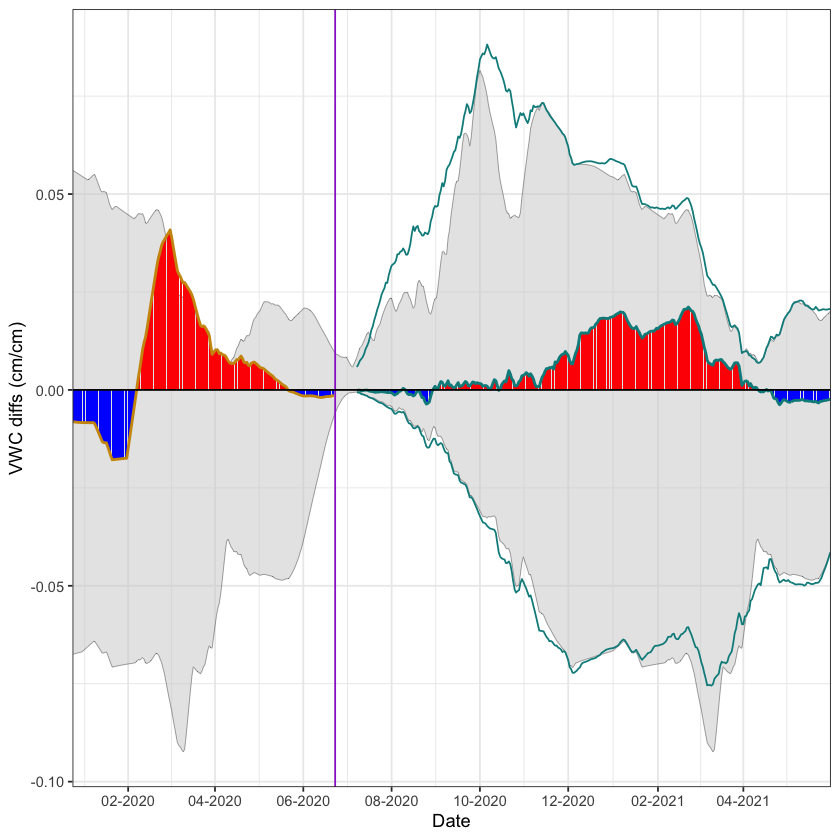

In [14]:
source('figureCode/presentationFigs/VWC.R')